In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np


from utils import ntf
from pipeline import PipelineGED

from transformers import logging
logging.set_verbosity_error()


# device = torch.device("cpu")
device = torch.device("cuda:0")

Simbert不能正常使用，除非你安装：bert4keras、tensorflow ，为了安装快捷，没有默认安装.... No module named 'bert4keras'


In [2]:
MODEL_SIZE = 'base'
MODEL_ARCH = 'roberta-word-based'


if MODEL_ARCH == 'ernie':
    model_name = 'nghuyong/ernie-gram-zh'
elif MODEL_ARCH == 'macbert':
    model_name = 'hfl/chinese-macbert-base' if MODEL_SIZE == 'base' else 'hfl/chinese-macbert-large'
elif MODEL_ARCH == 'roberta-word-based':
    model_name = 'uer/roberta-base-word-chinese-cluecorpussmall'
else:
    raise NotImplementedError(f'Model {MODEL_ARCH} is not implemented yet.')
ner_model_name = 'uer/roberta-base-finetuned-cluener2020-chinese'


max_length = 64 if MODEL_SIZE == 'base' else 64

test_dataset_config = {
    'model_name':model_name,
    # 'aux_model_name':ner_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':True, 
    'cut_all':False, 
}

train_dataset_config = {
    'model_name':model_name,
    # 'aux_model_name':ner_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':False, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':True, 
    'cut_all':False, 
}

ntf()

In [4]:
if MODEL_ARCH == 'macbert':
    checkpoints = [
        '../finetuned_models/ensemble/model0/checkpoint-2400/pytorch_model.bin',
    ]
elif MODEL_ARCH == 'ernie':
    checkpoints = [f'../finetuned_models/balanced_trial_ernie_gram/fold{i}/checkpoint-1910/pytorch_model.bin' for i in range(10)] 
elif MODEL_ARCH == 'roberta-word-based':
    checkpoints = [
        "../finetuned_models/word-based-roberta/model0/checkpoint-1500/pytorch_model.bin", 
        "../finetuned_models/word-based-roberta/model1/checkpoint-1000/pytorch_model.bin", 
        "../finetuned_models/word-based-roberta/model2/checkpoint-1500/pytorch_model.bin", 
        "../finetuned_models/word-based-roberta/model3/checkpoint-2000/pytorch_model.bin", 
        "../finetuned_models/word-based-roberta/model4/checkpoint-500/pytorch_model.bin", 
    ]
else:
    print(f'Model {MODEL_ARCH} is not implemented yet.')

data_configs = {
    'model_name':model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'split_words':False, 
    'cut_all':False, 
}
clf = PipelineGED(
    model_name=model_name, 
    data_configs=data_configs, 
    single_layer_cls=True, 
    model_architecture='bert_with_clf_head', 
)

def apply_ged_pipeline(texts, majority_vote=False):
    if majority_vote:
        return clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False, majority_vote=True)
    probs, seq_probs, err_char_lst = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=True, majority_vote=False)
    return probs, seq_probs, err_char_lst

100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


[CLS] ▁ 女娲 有一双 聪明 能干 的手 。 [SEP]
[]
[CLS] ▁ 女娲 有一双 能干 的手 。 [SEP]
[]
[CLS] ▁ 女娲 有一双 聪明的 手 。 [SEP]
[]


array([[0.7459095 , 0.25409052],
       [0.77852684, 0.2214732 ],
       [0.79078555, 0.20921443]], dtype=float32)

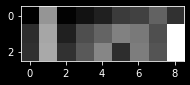

In [5]:
## 搭配
texts = [
    '女娲有一双聪明能干的手。', 
    '女娲有一双能干的手。', 
    '女娲有一双聪明的手。', 
]

probs, seq_probs, err_char = apply_ged_pipeline(texts)
probs

100%|██████████| 1/1 [00:00<00:00, 66.63it/s]


[CLS] ▁张 强 从小 生活在 爷爷奶奶 身边 , 因而 对父母 有着 浓厚的 感情 。 [SEP]
[]
[CLS] ▁张 强 从小 生活在 爷爷奶奶 身边 , 却 对父母 有着 浓厚的 感情 。 [SEP]
[]


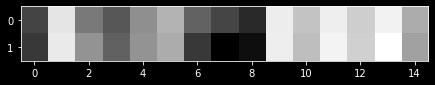

In [6]:
texts = [
    '张强从小生活在爷爷奶奶身边，因而对父母有着浓厚的感情。', 
    '张强从小生活在爷爷奶奶身边，却对父母有着浓厚的感情。',
]

probs, seq_probs, err_char = apply_ged_pipeline(texts)

100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


[CLS] ▁我们 不仅要 在 课外 学 语文 , 还要 在 课堂 中学 语文 。 [SEP]
[]
[CLS] ▁我们 不仅要 在 课堂 中学 语文 , 还要 在 课外 学 语文 。 [SEP]
[]


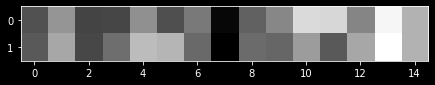

In [7]:
texts = [
    '我们不仅要在课外学语文，还要在课堂中学语文。', 
    '我们不仅要在课堂中学语文，还要在课外学语文。', 
]

probs, seq_probs, err_char = apply_ged_pipeline(texts)

100%|██████████| 1/1 [00:00<00:00, 15.57it/s]


[CLS] ▁ 小明 待人 非常 大方 友善 得很 。 [SEP]
['[CLS]', '非常', '得很', '[SEP]']
[CLS] ▁ 小明 待人 非常 大方 友善 。 [SEP]
[]


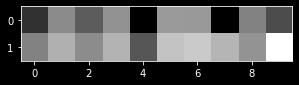

In [8]:
texts = [
    '小明待人非常大方友善得很。', 
    '小明待人非常大方友善。', 
]

probs, seq_probs, err_char = apply_ged_pipeline(texts)

100%|██████████| 1/1 [00:00<00:00, 27.45it/s]


[CLS] ▁ 他 为了 民族的 兴亡 和 人民 的利益 奋斗 了 一生 。 [SEP]
[]
[CLS] ▁ 他 为了 民族的 复兴 和 人民 的利益 奋斗 了 一生 。 [SEP]
[]


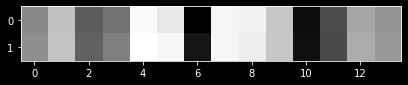

In [9]:
# 语义：单面对双面
texts = [
    '他为了民族的兴亡和人民的利益奋斗了一生。', 
    '他为了民族的复兴和人民的利益奋斗了一生。', 
]

probs, seq_probs, err_char = apply_ged_pipeline(texts)

100%|██████████| 1/1 [00:00<00:00, 26.75it/s]


[CLS] ▁ 我不禁 怀疑 这条 题目 是不是 老师讲 错了 。 [SEP]
['是不是']
[CLS] ▁ 我不禁 怀疑 这道 题目是 老师讲 错了 。 [SEP]
['[CLS]', '题目是', '老师讲']


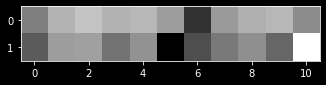

In [10]:
texts = [
    '我不禁怀疑这条题目是不是老师讲错了。', 
    '我不禁怀疑这道题目是老师讲错了。', 
]

probs, seq_probs, err_char = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True)


100%|██████████| 1/1 [00:00<00:00, 76.93it/s]

[CLS] ▁面对 经济 不断 下行 的 形势 , 政府 采取 了 一系列 措施 来 刺激 消费 , 以 促进 经济 繁荣 和 复苏 。 [SEP]
[]
[CLS] ▁面对 经济 不断 下行 , 政府 采取 了 一系列 措施 来 刺激 消费 , 以 促进 经济 繁荣 和 复苏 。 [SEP]
[]


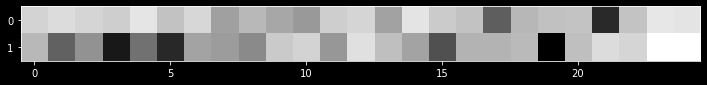

In [11]:
texts = [
    '面对经济不断下行的形势，政府采取了一系列措施来刺激消费，以促进经济繁荣和复苏。', 
    '面对经济不断下行，政府采取了一系列措施来刺激消费，以促进经济繁荣和复苏。'
]
probs, seq_probs, err_char = apply_ged_pipeline(texts)

100%|██████████| 1/1 [00:00<00:00, 34.77it/s]


[CLS] ▁从小 明 这 一个简单的 举动 中 , 可以让人 看出 他是一个 细心的 好孩子 。 [SEP]
['▁从小', '明', '中', ',']
[CLS] ▁ 小明 这 一个简单的 举动 , 可以让人 看出 他是一个 细心的 好孩子 。 [SEP]
[]


100%|██████████| 1/1 [00:00<00:00, 52.05it/s]

[CLS] ▁我想 , 人 是由 三部分 组成的 : 对 往事 的 追忆 、 对未来的 憧憬 和 对 现时 的把握 。 [SEP]
[]
[CLS] ▁我想 , 人 是由 三部分 组成的 : 对 往事 的 追忆 、 对 现时 的把握 和 对未来的 憧憬 。 [SEP]
[]


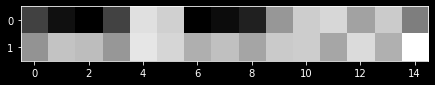

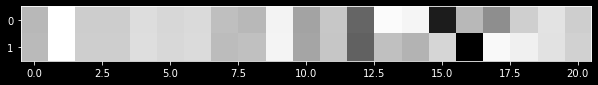

In [12]:
texts = [
    '从小明这一个简单的举动中，可以让人看出他是一个细心的好孩子。', 
    '小明这一个简单的举动，可以让人看出他是一个细心的好孩子。', 
]

probs, seq_probs, err_tokens = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True)

texts = [
    '我想，人是由三部分组成的：对往事的追忆、对未来的憧憬和对现时的把握。', 
    '我想，人是由三部分组成的：对往事的追忆、对现时的把握和对未来的憧憬。', 
]

probs, seq_probs, err_tokens = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True)

100%|██████████| 1/1 [00:00<00:00, 41.45it/s]


[CLS] ▁ 时光 的 流逝 不能 让我 淡 去 对 故乡 浓浓的 思念 , 反之 , 随着年龄的增 长 , 对 故乡 的 思念 愈发 日 久 弥 坚 。 [SEP]
[]
[CLS] ▁ 时光 的 流逝 不能 让我 淡 去 对 故乡 浓浓的 思念 , 反之 , 随着年龄的增 长 , 对 故乡 的 思念 日 久 弥 坚 。 [SEP]
[]


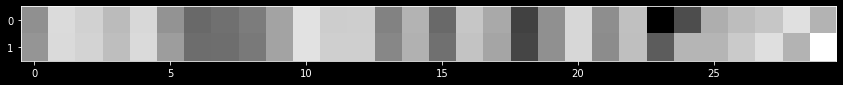

In [13]:
# 成分残缺/赘余

texts = [
    '时光的流逝不能让我淡去对故乡浓浓的思念，反之，随着年龄的增长，对故乡的思念愈发日久弥坚。', 
    '时光的流逝不能让我淡去对故乡浓浓的思念，反之，随着年龄的增长，对故乡的思念日久弥坚。', 
]

probs, seq_probs, err_tokens = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True)

100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


[CLS] ▁ 下午三点 整 , 参加 典礼 的 群众 全部 到 齐了 。 [SEP]
[]
[CLS] ▁ 下午三点 整 , 参加 典礼 的 群众 到 齐了 。 [SEP]
[]


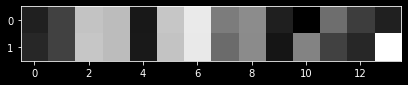

In [17]:
texts = [
    '下午三点整，参加典礼的群众全部到齐了。',
     '下午三点整，参加典礼的群众到齐了。',
]

probs, seq_probs, err_tokens = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True)

100%|██████████| 1/1 [00:00<00:00, 40.00it/s]

[CLS] ▁新 的土地 法 规定 , 农民 耕 种 的 符合 政策 规定的 自 留 地 是一种 正当 的 劳动 , 各级 政府 不得 以 各种理由 加以 干涉 。 [SEP]
[]
[CLS] ▁ 投资 环境 的好坏 , 服务质量 的优劣 , 政府 公务员 素质 的高低 , 都是 新 浦 新区 经济 健康发展 的重要 保证 。 [SEP]
[]
[CLS] ▁ 规规矩矩 的 两条 平行 线 , 始终是 两个 可 望 而 不可 及 的 端 点 。 [SEP]
[]
[CLS] ▁ 象征 中华民族 5000 年 文明的 考古 证据 在 辽 河流域 一再 被发现 , 证明 中华文明 起源 不是一个 中心 而是 多个 中心 , 其中包括 辽 河流域 在内的 燕山 南北 长城 地带 也是 中华文明 的 发 祥 地 之一 。 [SEP]
[]
[CLS] ▁ 他 为了 民族的 兴亡 和 人民 的利益 奋斗 了 一生 。 [SEP]
[]
[CLS] ▁ 熊猫 贝贝 这种 惊人的 生长 速度 , 是 和 食物的 充分 供应 以及 每天 喂食 时间 的 长短 成正比 的 。 [SEP]
[]
[CLS] ▁一个人 能 取得 卓越 的成就 , 并不 在于 他 就读 的学校 是 重点 还是 普通 , 而在于 他 是否 具备 成功 的特质 。 [SEP]
[]
[CLS] ▁这是 一句 正确 的话 。 [SEP]
[]
[[0.68340045 0.31659958]
 [0.6889049  0.31109512]
 [0.8730285  0.12697153]
 [0.6394654  0.36053464]
 [0.6767198  0.32328022]
 [0.54162806 0.45837194]
 [0.5578575  0.44214252]
 [0.7780355  0.22196448]]


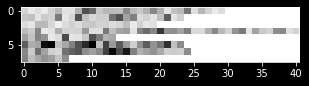

In [19]:
texts = [
    # '修建青藏铁路是加快西部大开发的重要举措，是民族团结的重要纽带。',
    # '《国家宝藏》用镜头带领观众走进博物馆，力图对每一件文物的前世今生进行总结与梳理，让观众在一眼万年中，感悟传统文化的深厚魅力。',
    # '中美双方希望通过此次访问增进互信、扩大合作、加强对话，推动中美关系健康稳定地向前发展。',
    # '微笑是一首动人的歌，它让我们的生活充满温馨。',
    # '上海科技开发中心聚集了一批热心于科技开发服务、善于经营管理的专业化队伍。',
    # '原疾控中心副主任杨功焕认为，如现有防控措施得到较好执行，疫情应该可以控制。',
    # '本协议自1985年1月1日起至1990年12月31日止，有效期5年，其间如无特殊原因，双方均有恪守协议的义务。',
    # '很多城市都有其独特的城市记忆，相关部门不能简单地用“有没有住过名人”、“有没有发生过著名事件”作为拆除老建筑的依据。',
    # '分小班能针对性地解决学生存在的各种问题。',
    # '2011年利润排名前40家企业，瓜分了6000多亿央企利润中的95%，其中有12家企业利润超过了100亿，这“十二豪门”囊括了央企总利润的78.8%。',
    # '九部门强调，严禁任何单位和个人在食品生产经营中使用食品添加剂以外的任何化学物质，严禁在农产品种植、加工、收购、运输中使用违禁药物或其他可能危害人体健康的物质。',
    # '《国家社科基金项目2010年度课题指南》近日发布，指南强调，基础理论研究要力求具有开拓性和原创性，应用对策研究要力求具有针对性和现实性，着力推出代表国家水平的哲学社会科学研究成果。', 
    # '诗歌中的意象是诗人所写的景与物，但这些意象又不再是单纯的景和物了，而是融入了诗人的情感，这些独特的物象实际上就是作者的外化。', 
    # '上海世博将充分交流城市建设经验和先进城市发展理念，探讨新的更好的人类居住、生活和工作的模式，为人类可持续发展留下一份丰厚的精神遗产。', 
    # '我们被统一的标准时间绑架住了，就像我们现在很多人的生活被北上广的时间和生活所绑架了一样，因此我们需要回到时间本身。',
    # '党的历史表明，群众路线执行得好坏，关系着革命和建设事业的成功。' , 
    # '女娲有一双聪明能干的手。', 
    # '大凡世界上的人物多是复杂的，好文章多是婉曲的，所以，我们的眼光也应婉曲、复杂些。', 
    # '1827年，雨果发表了《<克伦威尔>序言》，主张自然中存在的一切都可成为艺术题材，并且提出了美丑对照的审美原则，从而成为浪漫主义文学运动的宣言。', 
    # '为加强酒类的专卖管理，某市规定，凡是从外地订购的白酒，必须经市（县）专卖事业管理局批准，领取准购证后方得进货。', 
    # '全球有6700万人患有自闭症，而在中国，这个数字是1000万。虽然身边有着这么多的自闭症患者，但很多人对自闭症还是一个陌生的概念。', 
    # '亚洲文明对话大会不仅为世界文明发展指明了方向，而且促进了亚洲各国间的平等对话。', 
    # '荣获了“感动中国十大人物”的张艺谋在接受采访时，始终将自己的团队挂在嘴边，强调真正伟大的不是自己，而是自己的团队，自己的国家。',
    # '肿瘤专家认为吸烟或吸二手烟是引起肺癌的第一大诱因，而中国青少年吸烟率正在逐年上升，因此，教育部新近颁布的校园禁烟令受到了社会的肯定。',  
    # '对这家企业来说，现在要做的就是整顿，以度过当前的危机，让消费者重建对产品的信任。我想，这个过程是艰巨而漫长的。', 
    # '更多书刊将政策的善意倾注笔端，以此疏导社会情绪、纾解时代焦虑，决定着同心同德的发展共识是否会串联起亿万人民对于国家未来的憧憬和期待。', 
    # '艾青继承了中国古代知识分子“以天下为己任”的忧患意识，使他始终具有时代的使命感和忧国忧民的情怀。', 
    # '全球两个最大碳排放国的承诺，使过去五年五次全球气候谈判大会试图谈成的事，给谈成了。', 
    '新的土地法规定，农民耕种的符合政策规定的自留地是一种正当的劳动，各级政府不得以各种理由加以干涉。', 
    '投资环境的好坏，服务质量的优劣，政府公务员素质的高低，都是新浦新区经济健康发展的重要保证。', 
    '规规矩矩的两条平行线，始终是两个可望而不可及的端点。', 
    '象征中华民族5000年文明的考古证据在辽河流域一再被发现，证明中华文明起源不是一个中心而是多个中心，其中包括辽河流域在内的燕山南北长城地带也是中华文明的发祥地之一。', 
    '他为了民族的兴亡和人民的利益奋斗了一生。', 
    '熊猫贝贝这种惊人的生长速度，是和食物的充分供应以及每天喂食时间的长短成正比的。', 
    '一个人能取得卓越的成就，并不在于他就读的学校是重点还是普通,而在于他是否具备成功的特质。', 
    # '这次环保督查“回头看”，是为了有效纠正处分执行得是否到位的问题，真正发挥处分应有的警示、惩戒作用。',
    # '中国水稻专家说，凭借世界领先的超级杂交稻技术，13亿中国人不但可以吃得好，而且可以吃得饱。', 
    # '我们严肃地研究了职工们的建议。又虚心地征求了专家们的意见。',  
    # '这次比赛的获胜，将决定我们能否进入决赛阶段。', 
    # '时光的流逝不能让我淡去对故乡浓浓的思念，反之，随着年龄的增长，对故乡的思念愈发日久弥坚。'
    # '以损人利己手段牟取财富的，无论多少，都是肮脏的；而损人利己的致富者应视为“社会公敌”。', 
    # '《断章》只有短短4行，却试图用简明的意象阐释道理的深刻。诗人通过对“风景”的刹那间的感悟，涉及了“相对性”的哲理命题。', 
    # '在课堂教学中培养学生创新精神，是课堂教学改革成败的关键。', 
    # '面对这种保安员随意搜身的现象，人们不禁要问：他们的职责是保护商场的货物安全和环境安全，不是执法机构，怎么能擅自对顾客检查呢？', 
    # '希腊公共秩序部部长表示，希腊政府已经动用了反恐法并出动反恐部队来搜寻纵火犯，这意味着政府开始更加激进的措施应对国内森林大火。', 
    # '从无到有，中国航母出现在东方的海平面上。从试航、改装到正式入列，“辽宁舰”迈出的这一步注定是中国航母从梦想走向现实的一大步。', 
    # '许多学校的班级都参加了这次感恩节活动。', 
    # '今年辽宁旅游将以做精旅游产品、做强旅游企业、做好旅游服务为重点，推进旅游产业转型升级。', 
    # '住房公积金是指国家机关、企事业单位、外商投资企业、城镇私营企业及其他城镇企业及其在职职工缴存的长期住房储金，具有强制性。', 
    # '对一个国家而言，从宣示主权到管辖疆域，从资源勘探到建设规划，标准规范的地图不仅关系到国家安全、民族尊严，还反映着领土轮廓，作用重大，意义非凡。',
    # '2020年6月23日，我国成功发射了北斗三号最后一颗全球组网卫星，具备短报文能力，可以传送图像、打语音电话。', 
    # '路瓦栽夫人绕着脖子把项链挂在她那长长的高领上，站在镜子前对着自己的影子出神好半天。', 
    # '回首三年的初中生活，我们再一次明确了这样的道理：勤奋、踏实是学习成败的关键。', 
    # '而本设计所要求表现的美是野草之美，平常之美，那些被践踏、被遗忘、被鄙视的自然的美。', 
    # '屈原在《湘夫人》中表现了男女水神欢会难期、思而不见的爱情悲剧，实际上是他自己不为楚王所知的身世悲剧的曲折反映。', 
    # '沈从文创作的小说主要以湘西生活和都市生活为题材。前者通过都市生活的腐化堕落，揭示都市自然人性的丧失；后者通过描写湘西人原始、自然的生命形式，赞美人性美。', 
    # '9月15日，“天宫二号”成功发射，这不但为中国在2020年前后建成永久性空间站打下基础，而且使我国拥有了真正意义上的太空实验室。', 
    # '山上的水很宝贵，我们把它留给晚上来的人喝。', 
    # '中央经济工作会议是制定第二年宏观经济政策、判断当前经济形势最权威的风向标，也是每年度级别最高的经济工作会议。', 
    # '到明年，我省将形成开发、销售、生产、检测、服务为一体的新能源汽车产业发展体系。', 
    # '世界知识产权组织表示，高度发达经济体一直占据在全球创新指数中的主导地位，中国进入25强标志着中等收入国家首次进入高度发达经济体行列。', 
    # '庄子告诉我们，境界决定了人们对事物判断的正误，站在大境界上，就会看到天生我材必有用，而站在小境界上只能一生碌碌无为。', 
    # '古希腊时代之所以能创造出维纳斯、持矛者、掷铁饼者这些千古不朽的雕塑，是由于艺术家对人的完美形体有一种衷心的迷恋。', 
    # '该剧的意义在于，它以生动的画面和理念展示了新时期我军训练和生活的方方面面，揭开了新世纪“新军事题材电视剧”创作的序幕。', 
    # '他那无私的精神是我们学习的榜样。', 
    # '萨马兰奇2010年4月21日离开人世，这位老人曾为邓亚萍永不服输的精神而打动，他表示，邓亚萍的非凡成绩是她的天分、艰苦努力和不屈不挠的精神结合的结果，体现了奥运精神。', 
    # '珠三角地区作为国家实施“一带一路”战略的重要支点，贵广、南广高铁的开通，将使贵州等西南地区更广泛地融入“一带一路”之中。', 
    # '个人之所以成其为个人，以及他的生存之所以有意义，与其说是靠他个人的力量，也是由于他是人类社会的一个成员，社会在支配着他的物质生活和精神生活。', 
    # '最近，北京的社区除了食品、药店和日杂零售外，又出现了一些家居品牌社区店。',
    # '这家伙相当顽强，死也不肯坦白。', 
    # '食品添加剂的使用标准包括食品用加工助剂、胶母糖基础剂和食品用香料等2314个品种。', 
    # '整座大桥在河中的部分没有一个桥墩，桥身全靠铁索拉起，这在国内还是先例。', 
    # '由青年导演周申执导，开心麻花团队制作的影片《驴得水》，是一部2016年难得的兼具商业性和艺术性的现实主义荒诞喜剧片。', 
    # '《国家通用语言文字法》的实施、颁布是我国语文生活中的一件大事，标志着我国语言文字规范化、标准化工作开始走上法制轨道，进入一个新的发展时期。'
    # '一项数据显示，大约2%以上的普通人和40%~50%的持续性哮喘儿童对猫过敏，且对猫过敏的人或是狗的两倍。', 
    # '“十八大”报告中指出的“既不走封闭僵化的老路、也不走改旗易帜的邪路”，这是中国共产党人的坚定信念，是对当今世界格局、人类社会发展史的准确把握。', 
    # '4月27日，朝韩两国领导人在板门店会晒，为朝鲜半岛实现和平迈出了弥足珍贵的一步。'
    # '苹果公司不仅为广大用户提供创新产品及相关解决方案，更重视用户的应用体验，凭借专业精深的技术帮助用户加速采用以及有效使用苹果系列产品。', 
    # '全国国民阅读调查结果显示，国民人均纸质图书阅读量为4．77本，人均阅读电子书2．48本，超五成的成年国民认为自己的阅读数量较少。', 
    # '人们在生活中，实际上只需要遵守那些最基本的规则，而这些规则在幼儿园里就学过。', 
    '这是一句正确的话。', 
]
scores, _, _ = apply_ged_pipeline(texts)
print(scores)